# ARC Challenge With Inspect

## Overview

### Part A
- Setup - Normal benchmark - test/validation sets - Samples - inbuilt solvers and scorers
### Part B
- EvalSet - 2 models - Comparison - Analysis of Logs, Results 
### Part C
- LogProbs integration - custom solvers and scorers for different metrics(accuracy, stderr, mean over answers, confidence, topk etc), plots
### Part D
- If you allow for multiple answers - the models usually end up choosing more than is necessary. Even thought they get the right answer in a single answer setting.
1. Top logprobs for multi answers - are the 'just right' answers in top k?
2. Will letting the model know that there will be negative marking, ie., penalty by avg help?

(Probably not the right place to put this - but, can I just say that the ARENA nbs are absolutely delightful?! I have never gone from theory to building as fast or as confidently as I did with them. Brilliantly structured! This was fun!!)

## Summary of Analysis/Insights

### A. Basic
1. Model: gpt-4.1-nano.
2. Data: 250 samples from the validation set of the ARC challenge dataset.
3. Accuracy: 0.892, stderr: 0.020
4. solver, scorer: multiple_choice, choice (inbuilt)

### B. Moderate
1. Accuracy- on limit=250 samples from the validation set
    - gpt-4o-mini: 0.916
    - gpt-4.1-nano: 0.888
2. 
    - Questions that Model 1(gpt-4.1-nano) got right that Model 2(gpt-4o-mini) didn't: 10
    - Questions that Model 2(gpt-4o-mini) got right that Model 1(gpt-4.1-nano) didn't: 19
3. There are 14 questions that both models get wrong having chosen the same wrong options, and 3 questions that they get wrong choosing different wrong options.

    - Of these, atleast 1 had different labels ie., [1,2,3,4] instead of [A,B,C,D]. Since the model was prompted to respond with one of the labels it responded with '4' where the target was 'D'. Essentially, it got the answer right, but the question formatting was wrong. (Deliberate on the authors' part, I wonder?)

### C. Advanced

1. Set-up: Custom Scorers
    - Accuracy, stderr: Top K Winner, k=2 ie., a larger margin for error
    (Say you want to give it an easier chance of winning, so maybe take k=2
    ie., if the correct ans (target) is in the model's first 2 choices
    here, greedy pick is essentially k=1)
    - Accuracy, stderr: Greedy Pick - ie., acc and stderr of the ans its most confdent in
    - Mean score: Average % confidence over all records - by linear probability - for the target
    - Mean score: Average % confidence of greedy ans over all records - by linear probability

2. The greedy score, ie., the top choice with k=1 align with the initial comparisons above for both models.
3. The topk_winner scores, on the other hand, with just k=2, sees mini score a full accuracy = 1 and nano a close second with accuracy = 0.996 !
(ie., given just a very minute increase in margin for error - a second chance, essentially - the models generally get everything right?!)
4. Confidence is calculated as the linear probability from the logprobs of top-k answers. Top-conf., ie., the model's confidence in its top choice is at a 99% for mini and 97% for nano! 
5. Whereas the confidence in the actual, ground-truth target answer is a 90% and 87% for mini and nano respectively. This is because, well, they are generally confident of their top choices, regardless of whether they are right or wrong. So, when they get some questions wrong and the target differs, their confidence in their wrong answer remains - thus the lower scores.

### D. MC-MCQ - Multi-correct Answers

- What happens when models are told that there might be more than 1 answer to a question? A more realistic scenario might involve MCMCQs!
- Granted, the data being used doesnt have multi-correct answers-  which makes it even more concerning that models score abysmally(worse than normal) by choosing more options than are necessary.

- Set-up: Inspect's Multiple choice prompt for the user prompt. 
1. Without logprobs - Custom scorer: partial_choice which affords partial credit by averaging correct keys from the set of all returned keys in a multi-choice-multi-correct scenario. ie., in a multi-correct scenario, if the model had returned the perfect target it would have achieved a score of 1. Adding, say, just one other useless option brings the score down to 0.5.
    - Both models tend to over-answer 
    - gpt-4.1-nano - 0.803
    - gpt-4o-mini - 0.751
But mini was performing better all this while! The scores are significantly worse than from the single answer prompts above!

2. With logprobs- Custom scorers: A) Our penalising MCMCQ scorer and B) mc_topk_winner that calculates the accuracy by checking for the correct answer set in top k (here, k=2). Note that this requires an exact match.
So, if our required target isnt in top-k, the scorer doesnt even give partial credit- it gives 0.
Under this, we have 2 paradigms - w/ penalty and w/o penalty., ie., do we let the model know that it is being penalised?

3. w/o penalty - ie., normal prompt for MCMCQ, the model doesn't know that its being penalised for adding wrong answers.
    - Analysing the same with logprobs - ie., given that it returns the wrong answers, is the correct answer in topk? The scores below are for topk=2
    - mini - 0.816 (mc_topk_winner)
    - nano - 0.68 (mc_topk_winner)
    - The scores might be lower than the original MCMCQ scores - but these are not meant to be compared! Note definition  of B above.
    - See snapshots from the Inspect logs down below

4. w/ penalty - ie.,  What if you tell the model that there's a penalty for extra answers? 
    - Funnily enough - for some cases, the correct answer manages to make it to atleast one of topk=4, whereas in the previous case, it was nowhere to be found. The scores below are for topk=2
    - mini - 0.828 (mc_topk_winner)
    - nano - 0.756 (mc_topk_winner)
    - Slight improvement?





ENV

In [1]:
import os
import random
import re
import sys
import numpy as np
from functools import partial
from pathlib import Path
from pprint import pprint
from typing import Any, Literal

# from anthropic import Anthropic
from openai import OpenAI, AsyncOpenAI

import inspect_ai
from inspect_ai.dataset import Sample, hf_dataset
from inspect_ai.model import ChatMessageAssistant, ChatMessageSystem, ChatMessageUser

from inspect_ai import Task, eval, task
from inspect_ai.dataset import example_dataset

from inspect_ai.scorer import scorer, model_graded_fact, answer, choice, Scorer, Score, Target, accuracy, stderr, MetricProtocol, Metric
from inspect_ai.scorer import CORRECT, INCORRECT, Score
from inspect_ai.scorer._metrics import mean

from inspect_ai.solver import Choices
from inspect_ai.solver import chain_of_thought, generate, self_critique, multiple_choice
from inspect_ai.solver import Generate, Solver, TaskState, chain, solver, generate
from inspect_ai.model import GenerateConfig

from inspect_ai.log import read_eval_log
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px

from inspect_ai import eval_set

##### Secrets

In [2]:
assert os.getenv('OPENAI_API_KEY') is not None, "You must set your OpenAI API key"
openai_client = OpenAI()

# Part A

### Dataset & Samples

- Extract subsets of the 2.59k ARC-Challenge set-  The test set with 1.17k records & validation set with 299 records

In [ ]:


def arc_record_to_sample(record: dict[str, Any]) -> Sample:
    """    """
    labels = record["choices"]["label"]
    choices = record["choices"]["text"]

    target = chr(ord("A") + labels.index(record["answerKey"]))  # maps target label to A, B, C, ...
    input = [ChatMessageUser(content=record["question"])]  # should store input as list of ChatMessage objects
    metadata = zip(labels,choices)
    # return sample
    return Sample(input=input, choices=choices, target=target, metadata={"labels":labels})


val_dataset = hf_dataset(
    path="allenai/ai2_arc",
    name="ARC-Challenge",
    sample_fields=arc_record_to_sample,
    split="validation", 
    trust=True,
)
pprint(val_dataset.samples[0].__dict__)

In [55]:
test_dataset = hf_dataset(
    path="allenai/ai2_arc",
    name="ARC-Challenge",
    sample_fields=arc_record_to_sample,
    split="test", 
    trust=True,
)
pprint(test_dataset.samples[0].__dict__)

{'choices': ['Planetary density will decrease.',
             'Planetary years will become longer.',
             'Planetary days will become shorter.',
             'Planetary gravity will become stronger.'],
 'files': None,
 'id': None,
 'input': [ChatMessageUser(id='hgu8qVwF7ZkVkCmQkLFrjb', content='An astronomer observes that a planet rotates faster after a meteorite impact. Which is the most likely effect of this increase in rotation?', source=None, metadata=None, internal=None, role='user', tool_call_id=None)],
 'metadata': {'labels': ['A', 'B', 'C', 'D']},
 'sandbox': None,
 'setup': None,
 'target': 'C'}


In [56]:
LIMIT = 250

### Task

In [4]:
"""Model: GPT-4.1-nano"""
@task
def arc_eval_task(dataset):
  return Task(dataset =  dataset,
              # solver = [generate()],
              # scorer = match(),
              solver=multiple_choice(),
              # solver=multiple_choice(multiple_correct=True),
              scorer=choice(),
              # scorer=partial_choice(),
              )
m = "gpt-4.1-nano"
t = 'val'


In [ ]:
m = "gpt-4.1-nano"
t = 'val'
log = eval(arc_eval_task(val_dataset), 
           model=f"openai/{m}", log_dir = f"logs/{m}/{t}", limit = LIMIT)

In [59]:
# m = "gpt-4.1-nano"
# t = 'test'
# log = eval(arc_eval_task(t, test_dataset), 
#            model=f"openai/{m}", log_dir = f"logs/{m}/{t}")

In [60]:
"""Open in terminal"""
# !inspect view

'Open in terminal'

# Part B

### Comparison: GPT-4.1-nano and GPT-4o-mini 

In [ ]:

t = "val"
eval_set(
   tasks=[arc_eval_task(val_dataset)],
   model=["openai/gpt-4.1-nano", "openai/gpt-4o-mini"],
   log_dir="logs/comparison/val" ,
   # limit=LIMIT  ,
   retry_attempts=15
)

In [ ]:
#running the same eval set obj for the same path only continues eval and doesnt eval again is done
success, logs = eval_set(
   tasks=[arc_eval_task(val_dataset)],
   model=["openai/gpt-4.1-nano", "openai/gpt-4o-mini"],
   log_dir="logs/comparison/val" ,
   limit=LIMIT  ,
   retry_attempts=15
)

#### Performance

In [63]:
assert success 
logs

[EvalLog(version=2, status='success', eval=EvalSpec(eval_id='AbR4PUiT3hUGM9jqzBFdEE', run_id='FH5MUmDUn2NyNeB3VZJCoJ', created='2025-07-17T14:00:18+05:30', task='arc_eval_task', task_id='7PhUXSvyxobBdyfgsKhjp7', task_version=0, task_file=None, task_registry_name='arc_eval_task', task_attribs={}, task_args={'dataset': 'allenai/ai2_arc'}, task_args_passed={'dataset': 'allenai/ai2_arc'}, solver=None, solver_args=None, tags=None, dataset=EvalDataset(name='allenai/ai2_arc', location='allenai/ai2_arc', samples=299, sample_ids=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 1

In [64]:
# # # logs[0].eval.model
for i in range(len(logs)):
    print(i)
    log_file = str(logs[i].location)[7:]

    eval_log = read_eval_log(log_file)
    print(eval_log.eval.task)
    print(eval_log.eval.dataset)
    print(eval_log.eval.model)

    rec = eval_log.samples[0] #first record
    op_obj = rec.output.choices[0].message
    print(op_obj.id, op_obj.content)

# rec = eval_log.samples[0]
# q = rec.input[0].content
# # a = rec.output.choices[0].message
# t = rec.target
# c_i = rec.scores["choice"].value
# a = rec.scores["choice"].answer



0
arc_eval_task
name='allenai/ai2_arc' location='allenai/ai2_arc' samples=299 sample_ids=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204

In [65]:
eval_log.samples[0].choices

['Put the objects in groups.',
 'Change the height of the ramp.',
 'Choose different objects to roll.',
 'Record the details of the investigation.']

In [66]:
def log_to_df(eval_log):
    df = pd.DataFrame([
        {
            'question': sample.input[0].content,
            'answer': sample.scores["choice"].answer,
            'target': sample.target,
            'score': sample.scores["choice"].value,
            'model': eval_log.eval.model,
            'choices': sample.choices
        }
        for sample in eval_log.samples
    ])
    return df



In [67]:
accs = {}
errs = {}
df = pd.DataFrame()
for i in range(len(logs)):
    print(i)
    log_file = str(logs[i].location)[7:]

    eval_log = read_eval_log(log_file)
    model = eval_log.eval.model
    accs[model] = (eval_log.results.scores[0].metrics['accuracy'].value)
    errs[model] = (eval_log.results.scores[0].metrics['stderr'].value)
    df = pd.concat([df, log_to_df(eval_log)], ignore_index=True)


0
1


In [128]:
#compare metrics
model = sorted(accs.items(), key=lambda x : x[-1], reverse=True)
print("Model with better performance by Accuracy: " ,model[0])
model

Model with better performance by Accuracy:  ('openai/gpt-4o-mini', 0.919732441471572)


[('openai/gpt-4o-mini', 0.919732441471572),
 ('openai/gpt-4.1-nano', 0.8896321070234113)]

#### Extract Questions : one model > the other

In [69]:
def one_off(group): #to check for one-off answers given records filtered by question
    scores = group['score'].values
    models = group['model'].values
    
    if 'C' in scores and 'I' in scores:
        return group
    return pd.DataFrame()
one_off_df = df.groupby('question').apply(one_off).reset_index(drop=True)
one_off_df.head()

C:\Users\18055\AppData\Local\Temp\ipykernel_10360\3493662579.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  one_off_df = df.groupby('question').apply(one_off).reset_index(drop=True)


,question,answer,target,score,model,choices
0,A daphnia population shows a vertical migratio...,D,D,C,openai/gpt-4o-mini,"[the pH of the water, the clarity of the water..."
1,A daphnia population shows a vertical migratio...,B,D,I,openai/gpt-4.1-nano,"[the pH of the water, the clarity of the water..."
2,A mass of air is at an elevation of 1000 meter...,B,B,C,openai/gpt-4o-mini,"[Air particles move up and to the left., Air p..."
3,A mass of air is at an elevation of 1000 meter...,D,B,I,openai/gpt-4.1-nano,"[Air particles move up and to the left., Air p..."
4,A student plans an investigation to calculate ...,B,B,C,openai/gpt-4o-mini,"[the size of each ball, the thickness of the r..."


In [70]:
"""Where Model 1 > Model 2
Model 1 : openai/gpt-4.1-nano
Model 2 : openai/gpt-4o-mini
"""
m1 = 'openai/gpt-4.1-nano'
m2 = 'openai/gpt-4o-mini'
model1 = one_off_df[(one_off_df['model'] == m1) & (one_off_df['score'] == 'C')]
print("Questions that Model 1(gpt-4.1-nano) got right that Model 2(gpt-4o-mini) didn't:", len(model1))
model2 = one_off_df[(one_off_df['model'] == m2) & (one_off_df['score'] == 'C')]
print("Questions that Model 2(gpt-4o-mini) got right that Model 1(gpt-4.1-nano) didn't:", len(model2))

Questions that Model 1(gpt-4.1-nano) got right that Model 2(gpt-4o-mini) didn't: 10
Questions that Model 2(gpt-4o-mini) got right that Model 1(gpt-4.1-nano) didn't: 19


In [71]:
model1

,question,answer,target,score,model,choices
11,An animal has six legs. What is it most likely...,B,B,C,openai/gpt-4.1-nano,"[a spider, a fly, a lizard, a centipede]"
21,"In an automobile, which of the following compo...",B,B,C,openai/gpt-4.1-nano,"[steering wheel, speedometer, brake pedal, car..."
25,Many natural resources are found in Maryland a...,C,C,C,openai/gpt-4.1-nano,"[reduces air pollution, increases soil erosion..."
27,Ocean tides of Earth are strongly influenced b...,D,D,C,openai/gpt-4.1-nano,"[full and first quarter, full moon and new moo..."
35,Tracey was learning about structural organizat...,A,A,C,openai/gpt-4.1-nano,"[a cell, a tissue, a system, an organ]"
39,When a bowling ball is released from a bowler'...,D,D,C,openai/gpt-4.1-nano,"[stored in the ball until it hits the pins., i..."
43,Which is not a safety rule for the science lab?,A,A,C,openai/gpt-4.1-nano,"[Measure liquids accurately into a beaker., Ne..."
47,Which of the following stream characteristics ...,A,A,C,openai/gpt-4.1-nano,"[gradient, elevation, base level, water quality]"
49,Which of these behaviors did a bear most likel...,C,C,C,openai/gpt-4.1-nano,"[drinking water, eating fish, opening garbage ..."
55,Which statement describes asteroids and comets?,B,B,C,openai/gpt-4.1-nano,"[Asteroids are gaseous, and comets are solid.,..."


In [127]:
model2.question.to_list()

['A daphnia population shows a vertical migration from the bottom of a one-meter-deep pond during the day to the surface of the pond at night. To which factor is the daphnia population most likely responding?',
 'A mass of air is at an elevation of 1000 meters in the low pressure center of a Northern Hemisphere storm. Which of the following best describes the motion of air particles in this air mass due to storm conditions and the rotation of Earth as the air mass moves outward?',
 'A student plans an investigation to calculate the speeds of different balls as they roll down a ramp. Which piece of information is least necessary for the student to record?',
 'A student removes an ice cube tray from the freezer and places it on a table. The ice cubes are solid and cold. The student forgets to put the ice cube tray back into the freezer. The next day, the ice cubes should be',
 'After the last ice age, the melting of the polar and mountain ice caps caused the water levels of the oceans to

In [72]:
"""Analysis : Length"""

"""
1) Questions that nano got right but mini struggled with:
"""
#avg len of questions that mini got wrong
len1 = (df["question"].apply(lambda x:len(str(x))))
length_avg_mini = len1.mean()
#avg len of questions that nano got wrong
len2 = (model2["question"].apply(lambda x:len(str(x))))
length_avg_nano = len2.mean()

print("avg len of questions that mini got wrong: ", length_avg_mini)
print("avg len of questions that nano got wrong: ", length_avg_nano)

avg len of questions that mini got wrong:  133.82608695652175
avg len of questions that nano got wrong:  146.21052631578948


In [73]:
# 

#### Extract Questions : both get wrong

In [74]:
def both_off(group): #to check for one-off answers given records filtered by question
    scores = group['score'].values
    models = group['model'].values
    
    if 'C' not in scores :
        return group
    return pd.DataFrame()
both_off_df = (df.groupby('question').apply(both_off).reset_index(drop=True))
both_off_df = both_off_df.drop_duplicates(subset=['question', 'answer']) #ignore duplicate vals where both models answered with the same wrong answer.
both_off_df

C:\Users\18055\AppData\Local\Temp\ipykernel_10360\2108156291.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  both_off_df = (df.groupby('question').apply(both_off).reset_index(drop=True))


,question,answer,target,score,model,choices
0,A group of students is investigating two subst...,A,D,I,openai/gpt-4o-mini,"[by noticing if they dissolve in water, by stu..."
2,A microscope magnifies an object with 50x magn...,B,D,I,openai/gpt-4o-mini,"[100 cm, 25 cm, 2.5 cm, 0.01 cm]"
3,A microscope magnifies an object with 50x magn...,C,D,I,openai/gpt-4.1-nano,"[100 cm, 25 cm, 2.5 cm, 0.01 cm]"
4,A particular habitat has experienced many chan...,C,D,I,openai/gpt-4o-mini,"[a population with many individuals, great spe..."
6,"During an investigation, heat transferred from...",C,D,I,openai/gpt-4o-mini,"[The temperature of the liquid increased, or t..."
8,"For a science activity, Mia had to draw a pict...",B,D,I,openai/gpt-4o-mini,"[gibbous, full moon, new moon, first quarter]"
9,"For a science activity, Mia had to draw a pict...",C,D,I,openai/gpt-4.1-nano,"[gibbous, full moon, new moon, first quarter]"
10,In what way can soil nutrients in agricultural...,A,C,I,openai/gpt-4o-mini,"[overgrazing, wind erosion, increased irrigati..."
11,In what way can soil nutrients in agricultural...,B,C,I,openai/gpt-4.1-nano,"[overgrazing, wind erosion, increased irrigati..."
12,"Of the choices listed, which represents the na...",B,D,I,openai/gpt-4o-mini,"[reading a book about a prairie dog community,..."


In [75]:
"""Where both answer with the same wrong answer"""
#will have only 1 record - with the answer being that chosen by both models

"""Where both are wrong but offer different answers"""

both_off_df[both_off_df.duplicated(subset=['question'], keep=False)]


,question,answer,target,score,model,choices
2,A microscope magnifies an object with 50x magn...,B,D,I,openai/gpt-4o-mini,"[100 cm, 25 cm, 2.5 cm, 0.01 cm]"
3,A microscope magnifies an object with 50x magn...,C,D,I,openai/gpt-4.1-nano,"[100 cm, 25 cm, 2.5 cm, 0.01 cm]"
8,"For a science activity, Mia had to draw a pict...",B,D,I,openai/gpt-4o-mini,"[gibbous, full moon, new moon, first quarter]"
9,"For a science activity, Mia had to draw a pict...",C,D,I,openai/gpt-4.1-nano,"[gibbous, full moon, new moon, first quarter]"
10,In what way can soil nutrients in agricultural...,A,C,I,openai/gpt-4o-mini,"[overgrazing, wind erosion, increased irrigati..."
11,In what way can soil nutrients in agricultural...,B,C,I,openai/gpt-4.1-nano,"[overgrazing, wind erosion, increased irrigati..."


In [76]:
"""Analysing Questions Quality for all that both got wrong"""
for q, c in zip((both_off_df.question), both_off_df.choices):
    print(q, c)

A group of students is investigating two substances to determine which is table salt and which is table sugar. How would the students best identify each substance? ['by noticing if they dissolve in water', 'by studying the color of the substance', 'by observing if they stick to a surface', 'by examining the shape of the crystal']
A microscope magnifies an object with 50x magnification. How long is the object if the image appears to be 0.5 cm long? ['100 cm', '25 cm', '2.5 cm', '0.01 cm']
A microscope magnifies an object with 50x magnification. How long is the object if the image appears to be 0.5 cm long? ['100 cm', '25 cm', '2.5 cm', '0.01 cm']
A particular habitat has experienced many changes in environmental conditions over the last 75 years. Which is most likely a characteristic of a species that has the best chance to survive these environmental changes? ['a population with many individuals', 'great species diversity in the present community', 'adaptations that allow individuals t

Accuracies:
[('openai/gpt-4o-mini', 0.919732441471572),
 ('openai/gpt-4.1-nano', 0.8896321070234113)]

1. Some questions, both the models get wrong - most times with the same wrong answer - but sometimes (~3/14) answer with 2 different wrong options.

2. In cases where 1 models gets the correct answer and the other doesnt:
    Questions that Model 1(gpt-4.1-nano) got right that Model 2(gpt-4o-mini) didn't: 10
    Questions that Model 2(gpt-4o-mini) got right that Model 1(gpt-4.1-nano) didn't: 19




3. Specific Questions and what might be going wrong:

- A microscope magnifies an object with 50x magnification. How long is the object if the image appears to be 0.5 cm long? ['100 cm', '25 cm', '2.5 cm', '0.01 cm']
^ involves math 

- Certain questions like the following, the model gets right, but the options themselves are wrong.:
 In a car accident, a seat belt helps prevent injuries by applying a force

    '1) less than the force of the moving passenger', '2) greater than the force of the moving car', "3) in the same direction as the car's motion", "4) in the opposite direction of the passenger's motion"

    The model answers 4 which is essentially D - the target. Was this set up on purpose to check for over-fitting? Is this expected behaviour?





# Part C

## LogProbs

### Custom Solvers

In [77]:
SINGLE_ANSWER_TEMPLATE = r"""
Answer the following multiple choice question. The entire content of your response should be of the following format: 'LETTER' (without quotes) where LETTER is one of {letters}.

{question}

{choices}
""".strip()



In [78]:
@solver
def mcq_user_message() -> Solver:
    async def solve(state: TaskState, generate: Generate) -> TaskState:
        ch = [choice.value for choice in state.choices]
        l=state.metadata['labels']
        letters = ",".join(l)
        choices = [l[i]+') '+ch[i] for i in range(len(ch))] 
        # choices = dict(zip(letters, ch))
        # choices = ch
        state.user_prompt.text = SINGLE_ANSWER_TEMPLATE.format(question=state.user_prompt.text, 
                                                               choices=choices,
                                                               letters=letters)
        # print(state.user_prompt.text)

        return state

    return solve


In [ ]:
def logprobs_generate(model_name="gpt-4", topk=4):
    @solver
    def _logprobs_generate():
        async def solve(state, generate):
            client = AsyncOpenAI()
            messages = [{"role": "user", "content": state.user_prompt.text}]
            
            response = await client.chat.completions.create(
                model=model_name,
                messages=messages,
                logprobs=True,
                top_logprobs=topk,
            )

            state.output.completion = response.choices[0].message.content

            # print(state.output.completion)
            
            if response.choices[0].logprobs:
                logprobs_data = []
                for token in response.choices[0].logprobs.content:
                    logprobs_data.append({
                        'token': token.token,
                        'logprob': token.logprob,
                        'bytes': token.bytes,
                        'top_logprobs': [
                            {'token': t.token, 'logprob': t.logprob, 'bytes': t.bytes}
                            for t in token.top_logprobs
                        ] if token.top_logprobs else []
                    })
                
                # Store as plain dict to avoid serialization issues
                state.metadata['logprobs'] = logprobs_data
            
            return state

        return solve
    
    return _logprobs_generate()



### Custom Scorers

In [80]:
def linear_probability(logprob):
    return (np.exp(logprob))


In [81]:
@scorer(metrics=[accuracy(), stderr()])
def mcq_scorer() -> Scorer:
    async def score(state: TaskState, target: Target) -> Score:
        choices = [choice.value for choice in state.choices]
        letters=state.metadata['labels']
        explanation = state.output.completion
        tar = state.target
        logprobs = state.metadata['logprobs']


        explanation = explanation.strip().lower()
        target_matches_choices = ((target.text).strip().lower()) == (explanation)
        answers = [lp['token'] for lp in logprobs]
        
        # print(state.output.completion, explanation, target.text, ((target.text).strip().lower()), target_matches_choices)
        # print(logprobs)
        
        topks = [(lp['token'].strip().upper(), lp['logprob']) for lp in logprobs[0]['top_logprobs']]
        topk_toks = {}
        for (ans, lp) in topks:
            if ans in letters and ans not in topk_toks:
                topk_toks[ans] = lp

        state.metadata['topk'] = topk_toks

        probs = {} #all probs from lp
        for tok, lp in topk_toks.items():
            probs[tok] = linear_probability(lp)
        state.metadata['linprobs'] = probs
        
        return Score(
        value=CORRECT if target_matches_choices else INCORRECT,
        answer=", ".join(answers),
        explanation=explanation,
    )
    return score

"""Greedy Pick - ie., acc and stderr of the ans its most confdent in"""
@scorer(metrics=[accuracy(), stderr()])
def greedy_scorer()-> Scorer:
    async def score(state: TaskState, target: Target) -> Score:
        topk_toks = state.metadata['topk']
        probs = state.metadata['linprobs'] #all probs from lp
        
        explanation = state.output.completion
        explanation = explanation.strip()

        sort_p = sorted(probs.items(), key=lambda x: x[1], reverse=True)
        greedy_res = sort_p[0][0]
        top_prob = sort_p[0][1]
        target_matches_choices = ((target.text).strip().lower()) == (greedy_res.strip().lower())
        return Score(
            value=CORRECT if target_matches_choices else INCORRECT, #  greedy - ie., the most confident?
            metadata=probs #all confidence scores
        )
    return score


"""Average % confidence of greedy ans over all records - by linear probability"""
@scorer(metrics=[mean()])
def top_conf()-> Scorer:
    async def score(state: TaskState, target: Target) -> Score:
        topk_toks = state.metadata['topk']
        probs = state.metadata['linprobs'] #all probs from lp
        
        explanation = state.output.completion
        explanation = explanation.strip()

        top_prob = sorted(probs.items(), key=lambda x: x[1], reverse=True)[0][1]
        # print(topk_toks, probs, explanation)
        prob  = probs[explanation] if explanation in probs else 0#confidence in chosen answer
        #confidence in correct answer?
        # trg_prob = probs[state.target.text]
        return Score(
            value=top_prob*100, #  greedy - ie., the most confident?
            metadata=probs #all confidence scores
        )
    return score




"""Average % confidence over all records - by linear probability - for the target"""
@scorer(metrics=[mean()])
def trg_conf()-> Scorer:
    async def score(state: TaskState, target: Target) -> Score:
        topk_toks = state.metadata['topk']
        probs = state.metadata['linprobs'] #all probs from lp
        explanation = state.output.completion
        explanation = explanation.strip()
    
        # print(topk_toks, probs, explanation)
        prob  = probs[explanation] if explanation in probs else 0#confidence in chosen answer
        #confidence in correct answer?
        trg_prob = probs[state.target.text] if state.target.text in probs else 0
        return Score(
            value=trg_prob*100, # ll b greedy - ie., the most confident
            metadata=probs #all confidence scores
        )
    return score

"""Average confidence over all records - by normalised log probabilities of target/answer"""
@scorer(metrics=[mean()])
def norm_conf(of=None)-> Scorer:
    async def score(state: TaskState, target: Target) -> Score:
        topk_toks = state.metadata['topk']
        explanation = state.output.completion
        explanation = explanation.strip()

        probs = state.metadata['linprobs'] #all probs from lp
        tokens = probs.keys()
        Z = sum(probs.values()) or 1.0 
        norm_conf  = {l: probs[l] / Z for l in tokens}

        if of == "target":
            trg_prob = norm_conf[state.target.text] if state.target.text in norm_conf else 0
        else:#of the answer
            trg_prob = norm_conf[explanation] if explanation in norm_conf else 0

    
        # prob  = probs[explanation] if explanation in probs else 0#confidence in chosen answer
        # trg_prob = probs[state.target.text] if state.target.text in probs else 0

        
        return Score(
            value=trg_prob*100, # ll b greedy - ie., the most confident
            metadata=probs #all confidence scores
        )
    return score

"""Top K Winner"""
@scorer(metrics=[accuracy(), stderr()])
def topk_winner(k=2)-> Scorer:
    """
    Say you want to give it an easier chance of winning, so maybe take k=2
    ie., if the correct ans (target) is in the model's first 2 choices
    here, greedy pick is essentially k=1

    Or, say if the model's choice of probability for that token is > some x
    """
    async def score(state: TaskState, target: Target) -> Score:
        topk_toks = state.metadata['topk']
        explanation = state.output.completion
        explanation = explanation.strip()

        probs = state.metadata['linprobs'] #all probs from lp
        tokens = probs.keys()
    
        sort_p = sorted(probs.items(), key=lambda x: x[1], reverse=True)
        topktoks = [x[0] for x in sort_p]
        greedy_res = topktoks[:k]
        target_matches_choices = (explanation.upper() in greedy_res)

        return Score(
            value = CORRECT if target_matches_choices else INCORRECT, # ll b greedy - ie., the most confident
            metadata=probs #all confidence scores
        )
    return score



In [82]:

m1 = 'gpt-4.1-nano'
m2 = 'gpt-4o-mini'
limit = LIMIT
topk = 4

task = Task(
    dataset=val_dataset,
    plan=[mcq_user_message(), logprobs_generate(m1, topk)], 
    scorer=[mcq_scorer(),
            greedy_scorer(), 
            top_conf(), 
            trg_conf(),
            norm_conf("target"), #optional - if none given, calc conf of answer
            topk_winner(2)
            ]
)
logm1 = eval(task, 
           model=f"openai/{m1}", log_dir = f"logs/logprobs/{m1}/trash", limit = LIMIT)

Output()

In [83]:
task = Task(
    dataset=val_dataset,
    plan=[mcq_user_message(), logprobs_generate(m2, topk)], 
    scorer=[mcq_scorer(),
            greedy_scorer(), 
            top_conf(), 
            trg_conf(),
            norm_conf("target"), #optional - if none given, calc conf of answer
            topk_winner(2)
            ]
)
logm2 = eval(task, 
           model=f"openai/{m2}", log_dir = f"logs/logprobs/{m2}", limit = LIMIT)

Output()

So, given just a very minute increase in margin for error - a second chance, essentially - the models generally get everything right?!

In [84]:
m1logs = read_eval_log(logm1[0].location)
m2logs = read_eval_log(logm2[0].location)

In [130]:
def log_to_df2(eval_log):
    df = pd.DataFrame([
        {
            'question': sample.input[0].content,
            # 'answer': sample.scores["choice"].answer,
            'target': sample.target,
            # 'score': sample.scores["choice"].value,
            'model': eval_log.eval.model,
            'choices': sample.choices,
            'mcq_scorer' :  sample.scores['mcq_scorer'].value,
            'greedy_scorer' : sample.scores['greedy_scorer'].value,
            'topk_winner': sample.scores['topk_winner'].value,
            'top_conf': sample.scores['top_conf'].value,
            'trg_conf': sample.scores['trg_conf'].value,
            'norm_conf': sample.scores['norm_conf'].value

        }
        for sample in eval_log.samples
    ])
    return df



In [86]:
agg_scores1 = m1logs.results.scores
agg_scores2 = m2logs.results.scores

In [132]:
model_data = {}
model_data[m1] = {
"Normal": agg_scores1[0].metrics["accuracy"].value,
"Greedy": agg_scores1[1].metrics["accuracy"].value,
"TopK": agg_scores1[-1].metrics["accuracy"].value
}
model_data[m2] = {
"Normal": agg_scores2[0].metrics["accuracy"].value,
"Greedy": agg_scores2[1].metrics["accuracy"].value,
"TopK": agg_scores2[-1].metrics["accuracy"].value
}
conf_data = {}
conf_data[m1] = {
"Answer": agg_scores1[2].metrics["mean"].value,
"Target": agg_scores1[3].metrics["mean"].value,
"Norm": agg_scores1[4].metrics["mean"].value
}
conf_data[m2] = {
"Answer": agg_scores2[2].metrics["mean"].value,
"Target": agg_scores2[3].metrics["mean"].value,
"Norm": agg_scores2[4].metrics["mean"].value
}


In [88]:
def plot_acc(model_data, title, y, range):
    df_data = []
    for model, scores in model_data.items():
        for paradigm, accuracy in scores.items():
            df_data.append({
                'Model': model,
                'Scoring Paradigm': paradigm,
                y: accuracy
            })

    df = pd.DataFrame(df_data)
    fig_px = px.bar(df, 
                    x='Scoring Paradigm', 
                    y=y,
                    color='Model',
                    barmode='group',
                    title=title,
                    color_discrete_sequence=['#3498db', '#e74c3c'])

    fig_px.update_layout(
        xaxis_title='Scoring Paradigm',
        yaxis_title=y,
        yaxis=dict(range=range),
        template='plotly_white',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        width=500,
        height=400
    )

    fig_px.show()


In [89]:
plot_acc(model_data, 'Model Performance Comparison Across Scoring Paradigms', 'Accuracy', [0, 1.1])

In [90]:
plot_acc(conf_data, 'Model Performance Comparison Across Scoring Paradigms', 'Confidence', [0, 110])

In [133]:
model_data

{'gpt-4.1-nano': {'Normal': 0.872, 'Greedy': 0.88, 'TopK': 0.996},
 'gpt-4o-mini': {'Normal': 0.896, 'Greedy': 0.904, 'TopK': 1.0}}

In [ ]:
conf_data

{'gpt-4.1-nano': {'Answer': 97.84712556279268,
  'Target': 87.3372256089012,
  'Norm': 87.33973826074367},
 'gpt-4o-mini': {'Answer': 99.15370688156891,
  'Target': 90.0912833735274,
  'Norm': 90.09128664284134}}

: 

In [91]:
m1_df = log_to_df2(m1logs)
m2_df = log_to_df2(m2logs)
m1_df.head(1)

,question,target,model,choices,mcq_scorer,greedy_scorer,topk_winner,top_conf,trg_conf,norm_conf
0,Juan and LaKeisha roll a few objects down a ra...,D,openai/gpt-4.1-nano,"[Put the objects in groups., Change the height...",C,C,C,99.999218,99.999218,99.999264


1. The normal accuracy metric shows that gpt nano performs better than 4o mini. But given the chance ie., @topk=2, 4o mini chieves a 100% accuracy and nano is not too far behind.  
2. The confience data - calculated as linear probabilities from the log probs suggest that 4o mini is generally more confident than is nano in its answers. The target confidence is lower than the answer owing to all the answers that it didnt get right.


# Part D

## MC-MCQ

What happens when models are told that there might be more than 1 answer to a question? 

Granted, the data being used doesnt have multi-correct answers-  which makes it even more concerning that models score abysmally(worse than normal) by choosing more options than are necessary.

### W/O logprobs

- Both models tend to over-answer (given the normal multi-choice-correct prompt built in @inspect.ai) nd therefore achieve lower scores than they did when prompted for a single-answer.
- Wrong answers are penalised - ie., score=average

<i> choice() inbuilt scorer in Inspect only gives full credit for multi-correct answers - ie., no partial credit(avg over correct ans) 

In [92]:
MULTIPLE_ANSWER_TEMPLATE = r"""
Answer the following multiple choice question where multiple answers may be correct. The entire content of your response should be of the following format: 'LETTERS' (without quotes) where LETTERS is one or more of {letters}.

{question}

{choices}
""".strip()

MULTIPLE_ANSWER_TEMPLATE_PENALTY = r"""
Answer the following multiple choice question where multiple answers may be correct. The entire content of your response should be of the following format: 'LETTERS' (without quotes) where LETTERS is one or more of {letters}. Note that including wrong/extra answers will be penalised.

{question}

{choices}
""".strip()


In [93]:

"""Custom scorer: partial_choice which affords partial credit by averaging correct keys from the set of all returned keys in a multi-choice-multi-correct scenario"""

from inspect_ai.solver import Choices, TaskState
from inspect_ai.solver._multiple_choice import (
    answer_character,
    answer_index,
    answer_options,
    unshuffle_choices,
)
def _score_target(target: Target, choices: Choices) -> tuple[list[int], list[str]]:
    target_positions = [
        answer_index(target_character) for target_character in target.text
    ]

    choice_positions = [i for i, choice in enumerate(choices) if choice.correct is True]

    answers = [answer_character(choice) for choice in choice_positions]

    return target_positions, answers

@scorer(metrics=[mean(), accuracy(), stderr()])
def partial_choice() -> Scorer:
    async def score(state: TaskState, target: Target) -> Score:
            choices = state.choices

            explanation = state.output.completion

            target_positions, answers = _score_target(target, choices)

            generated_selected_choices = [
                i for i, choice in enumerate(choices) if choice.correct is True
            ]

            target_matches_choices = generated_selected_choices == sorted(target_positions)
            truth = [True if g in target_positions else False for g in generated_selected_choices]
            score = sum(truth) / len(truth) if len(truth) > 0 else 0.0

            return Score(
                # value=CORRECT if target_matches_choices else INCORRECT,
                value=score,
                answer=", ".join(answers),
                explanation=explanation,
            )

    return score

In [99]:
def mcmcq_task(dataset):
  return Task(dataset =  dataset,
              # solver = [generate()],
              # scorer = match(),
            #   solver=multiple_choice(),
              solver=multiple_choice(multiple_correct=True),
              scorer=partial_choice(),
              )

In [100]:
t = "val"
eval_set(
   tasks=[mcmcq_task(val_dataset)],
   model=["openai/gpt-4.1-nano", "openai/gpt-4o-mini"],
   log_dir=f"logs/comparison/mcmcq/{t}" ,
   limit=LIMIT ,
   retry_attempts=15
)

Output()

Completed all tasks in 'logs/comparison/mcmcq/val' successfully

(True, )

In [101]:
suc, logs_m1m2_mcmcq = eval_set(
   tasks=[mcmcq_task(val_dataset)],
   model=["openai/gpt-4.1-nano", "openai/gpt-4o-mini"],
   log_dir=f"logs/comparison/mcmcq/{t}" ,
   limit=100 ,
   retry_attempts=15
)

Completed all tasks in 'logs/comparison/mcmcq/val' successfully

On a MCMCQ task that is scored by penalising wrong answers: ie., count(correct_answers)/len(all_answers) :
- gpt-4.1-nano - 0.803
- gpt-4o-mini - 0.751

Which are significantly worse than the single answer probabilities above.


### W/ Logprobs

Analysing the same with logprobs - ie., given that it returns the wrong answers, is the correct answer in topk?

In [102]:
@solver
def mcmcq_user_message(penalty=False) -> Solver:
    async def solve(state: TaskState, generate: Generate) -> TaskState:
        ch = [choice.value for choice in state.choices]
        l=state.metadata['labels']
        letters = ",".join(l)
        choices = [l[i]+') '+ch[i] for i in range(len(ch))] 
        # choices = dict(zip(letters, ch))
        # choices = ch
        
        if penalty: #lets the model know of the penalty
            state.user_prompt.text = MULTIPLE_ANSWER_TEMPLATE_PENALTY.format(question=state.user_prompt.text, 
                                                               choices=choices,
                                                               letters=letters)
        else:
            state.user_prompt.text = MULTIPLE_ANSWER_TEMPLATE.format(question=state.user_prompt.text, 
                                                               choices=choices,
                                                               letters=letters)
        # print(state.user_prompt.text)

        return state

    return solve


In [103]:
def score_mc(tar, answer):
    score = 0
    for c in tar:
        if c.strip().upper() in answer:
            score += 1
    score = score/len(answer)
    return score

In [ ]:
@scorer(metrics=[accuracy(), stderr()])
def mcmcq_scorer() -> Scorer:
    async def score(state: TaskState, target: Target) -> Score:
        choices = [choice.value for choice in state.choices]
        letters=state.metadata['labels']
        explanation = state.output.completion
        tar = state.target
        logprobs = state.metadata['logprobs']
        answer = [c.strip().upper() for c in explanation]


        
        sc = score_mc(tar, answer)
        
        return Score(
        value=sc,
        answer=",".join(answer),
        explanation=explanation,
    )
    return score

"""Top K Winner"""
@scorer(metrics=[accuracy(), stderr()])
def mc_topk_winner(k=2)-> Scorer:
    """
    Say you want to give it an easier chance of winning, so maybe take k=2
    ie., if the correct ans (target) is in the model's first 2 choices
    here, greedy pick is essentially k=1

    Or, say if the model's choice of probability for that token is > some x
    """
    async def score(state: TaskState, target: Target) -> Score:
        choices = [choice.value for choice in state.choices]
        letters=state.metadata['labels']
        explanation = state.output.completion
        tar = state.target

        logprobs = state.metadata['logprobs']
        
        # topk_toks = state.metadata['topk']

        explanation = state.output.completion
        explanation = explanation.strip()

        target_matches_choices = False
        ans = ''
        conf = 0
        for lp in logprobs[0]['top_logprobs'][:k]: #top k
            answer = [c.strip().upper() for c in lp['token']]
            sc = score_mc(tar=tar, answer=answer)
            if sc == 1: #the perfect answer
                target_matches_choices = True
                conf = linear_probability(lp['logprob'])#confidence in correct answer - target
                ans = ",".join(answer) #final answer



        # probs = state.metadata['linprobs'] #all probs from lp
        # tokens = probs.keys()
    
        # sort_p = sorted(probs.items(), key=lambda x: x[1], reverse=True)
        # topktoks = [x[0] for x in sort_p]
        # greedy_res = topktoks[:k]
        # target_matches_choices = (explanation.upper() in greedy_res)

        return Score(
            value = CORRECT if target_matches_choices else INCORRECT, # ll b greedy - ie., the most confident
            answer= ans,
            metadata={'linprob(conf in) of trg ':conf} #all confidence scores
        )
    return score



#### Is the actual target anywhere near the top?

In [106]:

m1 = 'gpt-4.1-nano'
m2 = 'gpt-4o-mini'
limit = LIMIT
topk = 4

task = Task(
    dataset=val_dataset,
    plan=[mcmcq_user_message(), logprobs_generate(m1, topk)], 
    scorer=[mcmcq_scorer(),
            mc_topk_winner(2)
            ]
)
logm1_lp_mcmcq = eval(task, 
           model=f"openai/{m1}", log_dir = f"logs/logprobs/comparison/wop", limit = limit)

task = Task(
    dataset=val_dataset,
    plan=[mcmcq_user_message(), logprobs_generate(m2, topk)], 
    scorer=[mcmcq_scorer(),
            mc_topk_winner(2)
            ]
)
logm2_lp_mcmcq = eval(task, 
           model=f"openai/{m2}", log_dir = f"logs/logprobs/comparison/wop", limit = limit)

Output()

Output()

Note: The original mcmcq score might be > the top k score ie., there might be cases where mcmcq affords partial credit, but the actual target is nowhere to be found in topk

For eg: - here, target = D, answer = BD, and the topk answers progressively worsen :')

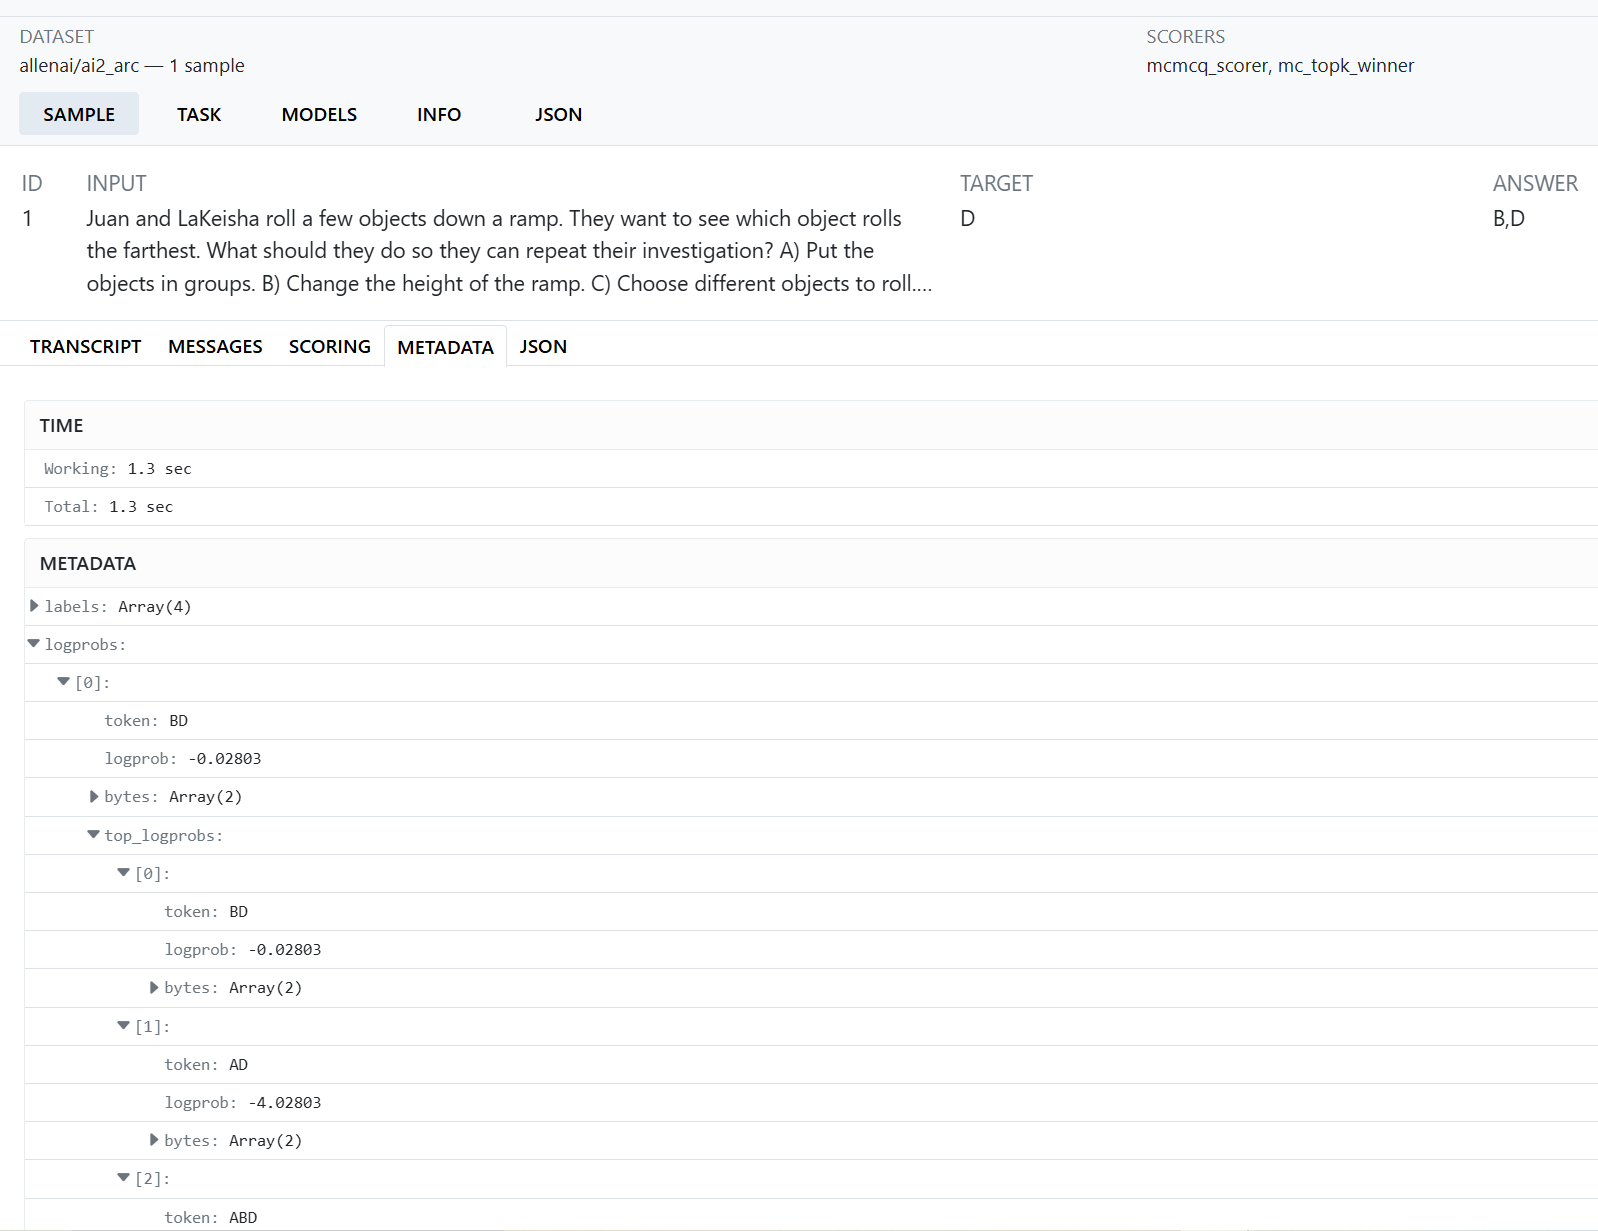

#### What if you tell the model that there's a penalty for extra answers?

In [109]:

m1 = 'gpt-4.1-nano'
m2 = 'gpt-4o-mini'
limit = LIMIT
topk = 4

task = Task(
    dataset=val_dataset,
    plan=[mcmcq_user_message(True), logprobs_generate(m1, topk)], 
    scorer=[mcmcq_scorer(),
            mc_topk_winner(2)
            ]
)
logm1_lp_wp = eval(task, 
           model=f"openai/{m1}", log_dir = f"logs/logprobs/comparison/wp", limit = limit)

task = Task(
    dataset=val_dataset,
    plan=[mcmcq_user_message(True), logprobs_generate(m2, topk)], 
    scorer=[mcmcq_scorer(),
            mc_topk_winner(2)
            ]
)
logm2_lp_wp = eval(task, 
           model=f"openai/{m2}", log_dir = f"logs/logprobs/comparison/wp", limit = limit)

Output()

Output()

Funnily enough - in this case, the correct answer (D) manages to make it to top 3, whereas in the previous case, it was nowhere to be found in tok4 - though the actual confidence/prob/logprob is so bad its almost useless

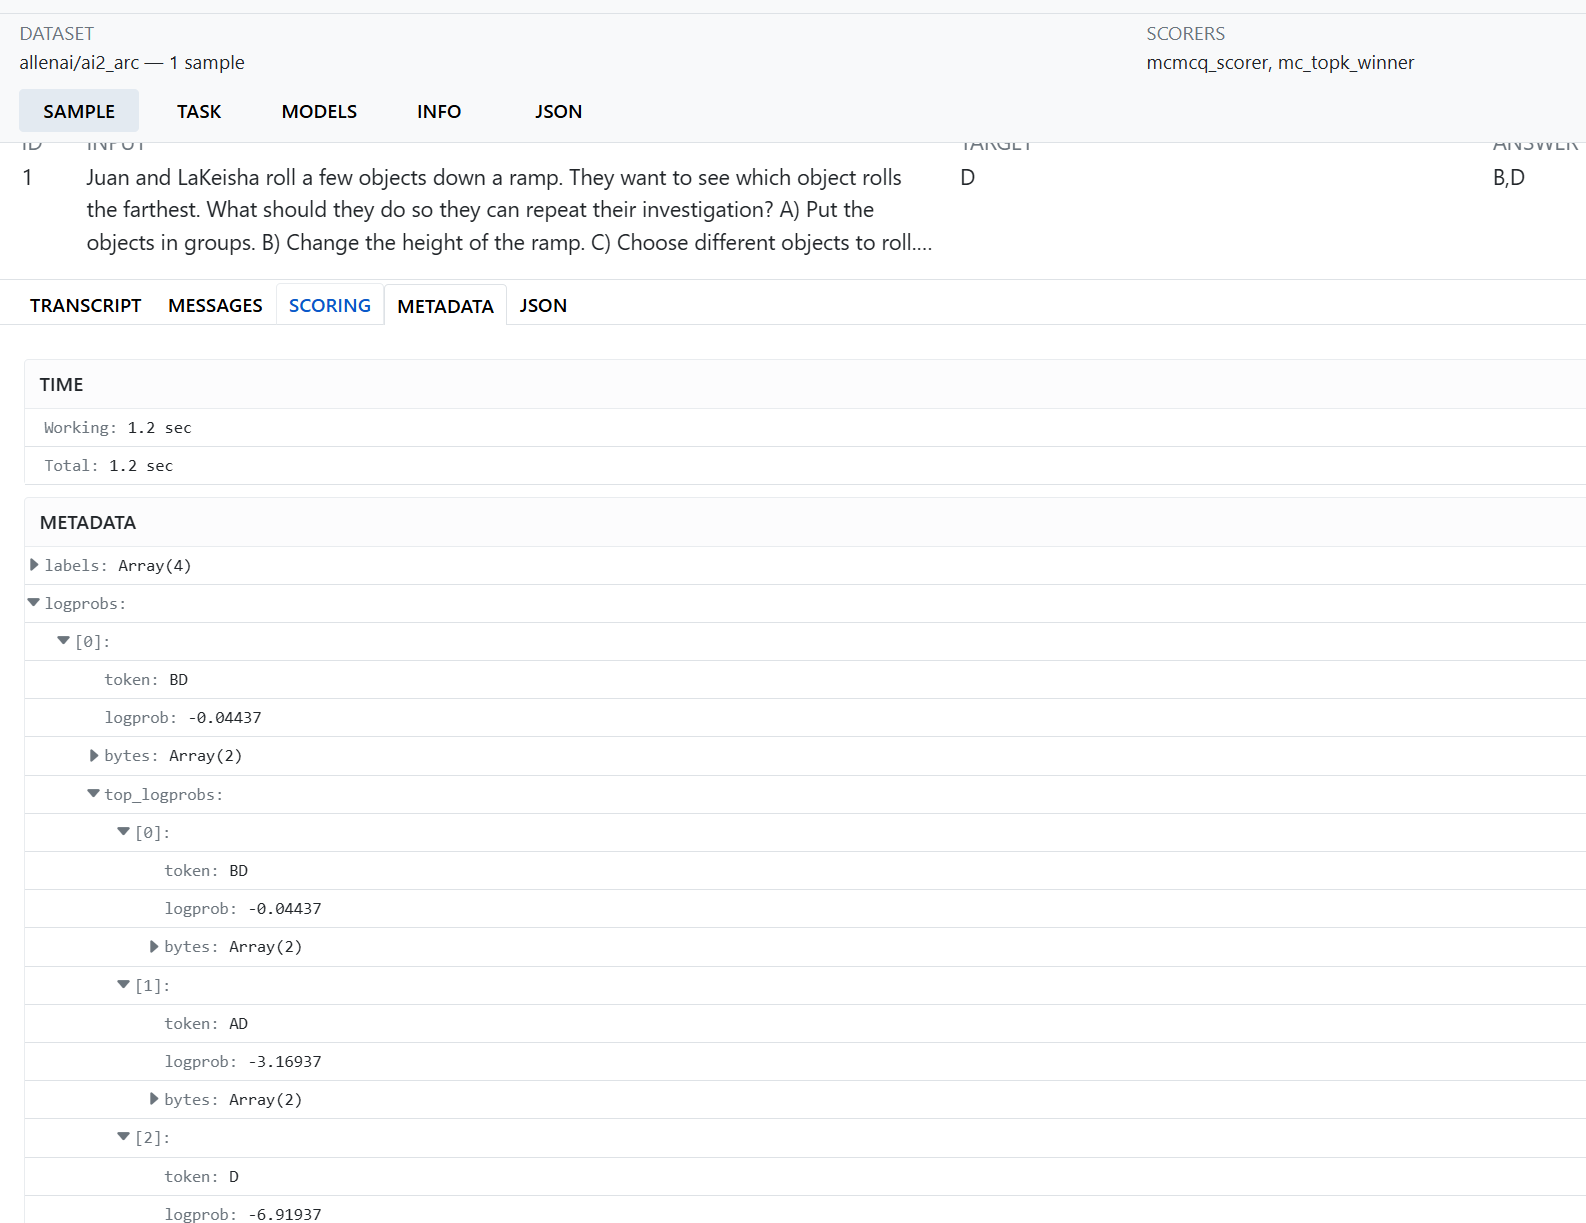